In [ ]:
from model.vision_transformer.dual_efficient_vit import DualEfficientViT
import torch
from torchsummary import summary

torch.manual_seed(0)
image = torch.randn((3, 3, 128, 128))
freq = torch.randn((3, 1, 128, 128))

model = DualEfficientViT(image_size=128, patch_size=1, version="cross_attention-freq-add", weight=0.5)

out = model(image, freq)
out

In [ ]:
import torch.nn as nn
import torch

class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, weights=None, eps=1e-7):
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.weights = weights      # [class_0, class_1]
        self.eps = eps
        
    def forward(self, pred, target):    # target: (batch_size, ), pred: (batch_size, )
        pred = pred.clamp(self.eps, 1-self.eps)
        if self.weights is not None:
            loss = self.weights[1] * (target * torch.log(pred)) + self.weights[0] * ((1- target) * torch.log(1-pred))
        else:
            loss = target * torch.log(pred) + (1 - target) * torch.log(1-pred)
        return torch.mean(torch.neg(loss))
    
# class_0, class_1 = 1, 4
# total = class_0 + class_1
# weights = [0.5 * total/class_0, 0.5 * total/class_1]
# wbce = WeightedBinaryCrossEntropy(weights=weights)

# print(weights)
# target = torch.tensor([0.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
# pred = torch.tensor([0.4, 0.6, 1.0, 1.0, 0.6])

# loss = wbce(target, pred)
# print(loss)

print("TEST")
bce = nn.BCELoss(reduction='none')
wbce = WeightedBinaryCrossEntropy(weights=[1,1])
pred = torch.rand((6))
tar = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32)
print("target = ", tar )
print("pred = ", pred)
print(bce(pred, tar))
wbce(pred, tar)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weights=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.weights = weights      # [class_0, class_1] và class_0 + class_1 = 1
        self.gamma = gamma
        self.eps = eps
    
    def forward(self, pred, target):
        pred = pred.clamp(self.eps, 1 - self.eps)
        if self.weights is not None:
            loss = self.weights[1] * ((1 - pred) ** self.gamma) * target * torch.log(pred) + self.weights[0] * (pred ** self.gamma) * (1 - target) * torch.log(1 - pred)
        else:
            loss = ((1 - pred) * self.gamma) * target * torch.log(pred) + (pred ** self.gamma) * (1 - target) * torch.log(1 - pred)
        return torch.mean(torch.neg(loss))

print("Test loss")
torch.manual_seed(4)
# target = torch.tensor([0.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
# pred = torch.tensor([0.2, 0.8, 0.8, 0.8, 0.8])

batch = 4
pred = torch.rand((batch, ))
tar = torch.randint(0, 2, (batch, ))
num_0 = (tar > 0).to(torch.int32).sum().item()
num_1 = (tar == 0).to(torch.int32).sum(0).item()

print("Pred: ", pred)
print("Target: ", tar.shape)
print("Numner: ", num_0, num_1)
weights = [num_1 / (num_0 + num_1), num_0 / (num_0 + num_1)]
print(weights)

fl = FocalLoss(weights=weights, gamma=0.5)
fcloss = fl(pred, tar)

wbce = WeightedBinaryCrossEntropy(weights=weights)
wbceloss = wbce(pred, tar)

print("Focal loss: ", fcloss)
print("WBCE loss: ",wbceloss)


In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5):  
        super(DualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
                print("Extractor: ", extractor)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
            # for i in range(0, len(extractor._blocks)):
            #     for index, param in enumerate(extractor._blocks[i].parameters()):
            #         if i >= len(extractor._blocks) - 3:
            #             param.requires_grad = True
            #         else:
            #             param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights


    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = DualEfficientViT(image_size=256, patch_size=2)
    out = model_(x, y)
    print(out.shape)
    from torchsummary import summary
    summary(model_, [(3, 256, 256), (1, 256, 256)], device="cpu")

In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualEfficientViTV2(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5):  
        super(DualEfficientViTV2, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
            # for i in range(0, len(extractor._blocks)):
            #     for index, param in enumerate(extractor._blocks[i].parameters()):
            #         if i >= len(extractor._blocks) - 3:
            #             param.requires_grad = True
            #         else:
            #             param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, freqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == freqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, freqs, freqs)
        return attn_outputs, attn_weights


    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, freq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            out_attn = torch.bmm(attn_weights, freq_vectors)

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = DualEfficientViTV2(image_size=256, patch_size=2)
    out = model_(x, y)
    print(out.shape)

In [ ]:
from model.cnn.srm_2_stream_net.srm_2_stream import Two_Stream_Net
import torch

model = Two_Stream_Net(num_classes=1, pretrained="/mnt/disk1/phucnp/Graduation_Thesis/review/forensics/dl_technique/xception-b5690688.pth")
dummy = torch.rand((32,3,128,128))
out = model(dummy)
print(out.shape)

In [ ]:
from plot_result import plot_graph

for iter_method in ['epoch', 'step']:
    print(iter_method)
    plot_graph("/mnt/disk1/phucnp/Graduation_Thesis/review/forensics/dl_technique/checkpoint/uadfv/dual_cross_attn/v_cross_attention-freq-add_w_0.8_lr_128_patch_0.0003_es_2_loss_none_freeze_bce/{}/result_test.csv".format(iter_method))

In [ ]:
from metrics.metric import *
from sklearn import metrics
from dataloader.gen_dataloader import *
from tqdm import tqdm
from model.vision_transformer.dual_efficient_vit import DualEfficientViT
import time
import os.path as osp

import torch

import torch.nn as nn

def eval_dual_stream(model, criterion, test_dir='',image_size=256, \
            batch_size=16, num_workers=8, checkpoint="checkpoint", resume="", \
            adj_brightness=1.0, adj_contrast=1.0, show_time=False, model_name="", args_txt=""):

      # Defines device and push model and loss module to device
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      model = model.to(device)
      criterion = criterion.to(device)

      # Load trained model
      try:
            model.load_state_dict(torch.load(osp.join(checkpoint, resume), map_location=device))
      except:
            print("ERROR !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("model khong ton tai: ", osp.join(checkpoint, resume) + '.pt')
            return

      # Make dataloader
      dataloader_test = generate_test_dataloader_dual_stream(test_dir, image_size, batch_size, num_workers, adj_brightness=adj_brightness, adj_contrast=adj_contrast)

      test_loss = 0.0           # global loss of all images
      test_accuracy = 0.0       # global accuracy of all images
      model.eval()
      
      y_label = []              # save ground truth labels  [0, 0, 1, 1...]           - (num_images, ) 
      y_pred = []               # save output of all images [0.05, 0.4, 0.6, 0.4...]  - (num_images, )
      y_pred_label = []         # save predicted labels     [0, 0, 1, 0...]           - (num_images, )
      
      with torch.no_grad():
            for inputs, fft_imgs, labels in tqdm(dataloader_test):
                  begin = time.time()
                  # Push groundtruth label (original) to cpu and save in a list
                  y_label.extend(labels.cpu().numpy().astype(np.float64))
                  # Push input to device and forward to model
                  inputs, fft_imgs, labels = inputs.float().to(device), fft_imgs.float().to(device), labels.float().to(device)
                  logps = model.forward(inputs, fft_imgs)      # shape (batchsize, 1)
                  logps = logps.squeeze()                      # shape (batchsize, )   
                  
                  # Push predicted output - in [0, 1] to cpu and save in a list
                  logps_cpu = logps.cpu().numpy()
                  y_pred.extend(logps_cpu.astype(np.float64))
                  # breakpoint()
                  
                  # Show batch processing time
                  if show_time:
                        print("Time : ", time.time() - begin)
                  
                  # Calculate loss
                  batch_loss = criterion(logps, labels)
                  test_loss += batch_loss.item()

                  # Find predicted label, 0 or 1 and save in a list
                  equals = labels == (logps > 0.5)
                  pred_label = (logps_cpu > 0.5)
                  y_pred_label.extend(pred_label)
                  
                  # Calculate mean accuracy
                  test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                  
      # breakpoint()
      # import pdb; pdb.set_trace()
      # from IPython.core.debugger import Tracer; Tracer()()
      # from IPython.core.debugger import set_trace; set_trace()
      ######## Calculate metrics:
      test_loss /= len(dataloader_test)
      test_accuracy /= len(dataloader_test)
      # built-in methods for calculating metrics
      y_label = np.array(y_label, dtype=np.float64)
      y_pred_label = np.array(y_pred_label, dtype=np.float64)
      
      custom_accuracy = accuracy_score(y_label, y_pred_label)
      sklearn_acc = metrics.accuracy_score(y_true=y_label, y_pred=y_pred_label)
      
      custom_pre_0 = precision_score(y_label, y_pred_label, average='binary', pos_label=0)
      sklearn_pre_0 = metrics.precision_score(y_label, y_pred_label, average='binary', pos_label=0)
      
      custom_pre_1 = precision_score(y_label, y_pred_label, average='binary', pos_label=1)
      sklearn_pre_1 = metrics.precision_score(y_label, y_pred_label, average='binary', pos_label=1)
      
      custom_pre_micro = precision_score(y_label, y_pred_label, average='micro')
      sklearn_pre_micro = metrics.precision_score(y_label, y_pred_label, average='micro')

      custom_pre_macro = precision_score(y_label, y_pred_label, average='macro')
      sklearn_pre_macro = metrics.precision_score(y_label, y_pred_label, average='macro')
      
      custom_rec_0 = recall_score(y_label, y_pred_label, average='binary', pos_label=0)
      sklearn_rec_0 = metrics.recall_score(y_label, y_pred_label, average='binary', pos_label=0)
      
      custom_rec_1 = recall_score(y_label, y_pred_label, average='binary', pos_label=1)
      sklearn_rec_1 = metrics.recall_score(y_label, y_pred_label, average='binary', pos_label=1)
      
      custom_rec_micro = recall_score(y_label, y_pred_label, average='micro')
      sklearn_rec_micro = metrics.recall_score(y_label, y_pred_label, average='micro')

      custom_rec_macro = recall_score(y_label, y_pred_label, average='macro')
      sklearn_rec_macro = metrics.recall_score(y_label, y_pred_label, average='macro')
      
      custom_f1_0 = f1_score(y_label, y_pred_label, average='binary', pos_label=0)
      sklearn_f1_0 = metrics.f1_score(y_label, y_pred_label, average='binary', pos_label=0)
      
      custom_f1_1 = f1_score(y_label, y_pred_label, average='binary', pos_label=1)
      sklearn_f1_1 = metrics.f1_score(y_label, y_pred_label, average='binary', pos_label=1)
      
      custom_f1_micro = f1_score(y_label, y_pred_label, average='micro')
      sklearn_f1_micro = metrics.f1_score(y_label, y_pred_label, average='micro')

      custom_f1_macro = f1_score(y_label, y_pred_label, average='macro')
      sklearn_f1_macro = metrics.f1_score(y_label, y_pred_label, average='macro')
      
      print("Custom :  ", custom_accuracy, custom_pre_0, custom_pre_1, custom_pre_micro, custom_pre_macro, custom_rec_0, custom_rec_1, custom_rec_micro, custom_rec_macro, custom_f1_0, custom_f1_1, custom_f1_micro, custom_f1_macro)
      print("Sklearn : ", sklearn_acc, sklearn_pre_0, sklearn_pre_1, sklearn_pre_micro, sklearn_pre_macro, sklearn_rec_0, sklearn_rec_1, sklearn_rec_micro, sklearn_rec_macro, sklearn_f1_0, sklearn_f1_1, sklearn_f1_micro, sklearn_f1_macro)
      print("Micro: ", custom_pre_micro, custom_rec_micro, custom_f1_micro)
      assert custom_f1_micro == custom_pre_micro, "1"
      assert custom_f1_micro == custom_rec_micro, "2"

model = DualEfficientViT(image_size=128, patch_size=2, heads=3, depth=4, version="cross_attentio-freq-add",weight=0.8, freeze=0)
checkpoint='/mnt/disk1/phucnp/Graduation_Thesis/review/forensics/dl_technique/checkpoint/uadfv/dual_efficient_vit/(0.95_0.95_0.95)_v_cross_attention-freq-add_w_0.8_lr_0.0003_patch_2_h_3_d_4_es_none_loss_bce_freeze_0/epoch'
resumes=['model_last_30.pt', 'best_test_acc_0.947195.pt', 'best_test_loss_0.136948.pt']
criterion = nn.BCELoss()
test_dir = '/mnt/disk1/phucnp/Dataset/df_in_the_wild/image/test'
for resume in resumes:
      eval_dual_stream(model, criterion, test_dir, image_size=128, batch_size=64, num_workers=4, checkpoint=checkpoint, resume=resume)
      print()

In [ ]:
a = [1, 2]
print(type(a))

In [ ]:
y_label =       np.array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1], dtype=np.float64)
y_pred_label =  np.array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0], dtype=np.float64)

label = 0
tp_1 = np.sum((y_label == label) * (y_pred_label == label))
label = 1
tp_2 = np.sum((y_label == label) * (y_pred_label == label))
print(tp_1)
print(tp_2)

In [ ]:
import numpy as np

from sklearn import metrics
from metrics.metric import *
from module.train_torch import calculate_metric
import warnings
warnings.filterwarnings('ignore')

def precision_score(y_label: np.ndarray, y_pred_label: np.ndarray, average='binary', pos_label=1):
    score = -1
    if average == 'binary':
        tp = np.sum((y_label == pos_label) * (y_pred_label == pos_label))
        fp = np.sum((y_label == 1 - pos_label) * (y_pred_label == pos_label))
        print("tp: ", tp)
        print("fp: ", fp)
        print("tp+fp: ", np.sum(y_pred_label == pos_label))
        score = 1.0 * tp / (tp + fp)
    elif average == 'micro':
        tp = np.sum(y_label == y_pred_label)
        fp = np.sum(y_label != y_pred_label)
        score = 1.0 * tp / (tp + fp)

    else:   # 'macro'
        score_0 = precision_score(y_label, y_pred_label, pos_label=0)
        score_1 = precision_score(y_label, y_pred_label, pos_label=1)
        score = (score_0 + score_1) / 2
    return score

def read_txt(file: str):
    res = []
    with open(file, 'r') as f:
        s = f.read()
        s = s.replace("=", "").replace("*", "").replace("\s", "").replace("\n", "").replace("\t", "")
        res = list(map(float, s.split(",")))
    return np.array(res, dtype=np.float32)

y_label = read_txt("result/y_label.txt")
y_pred_label = read_txt("result/y_pred_label.txt")
print("len: ", len(y_label), len(y_pred_label))
y_pred_label = read_txt("result/y_pred_label.txt")

# acc, real, fake, mic, mac
print("acc, real, fake, mic, mac")
print(calculate_metric(y_label, y_pred_label))
print(calculate_cls_metrics(y_label, y_pred_label))
precision_score(y_label, y_pred_label, average='binary', pos_label=1)
print("y_label: ")
print("y_pred_label: ", y_pred_label)

In [37]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet
from pytorchcv.model_provider import get_model

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


class DualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15, \
                 flatten_type="patch", \
                 version="ca-scat-0.5", unfreeze_layers=-1):  
        super(DualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        self.version = version
        self.flatten_type = flatten_type  # in ['patch', 'channel']
        self.weight = float(version.split('-')[-1])

        self.spatial_extractor = self.get_feature_extractor(unfreeze=unfreeze_layers, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(unfreeze=unfreeze_layers, num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()
        
        self.reduce_dim = nn.Linear(self.num_patches, 1)

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", unfreeze=-1, pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            if unfreeze:
            # Freeze the first (num_blocks - <>) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == "xception_net":
            net = get_model("xception", pretrained=pretrained)
            extractor = nn.Sequential(*list(net.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if unfreeze:
                cnt = 0
                blocks = len(*list(extractor[0].children()))
                for block in extractor[0].children():
                    cnt += 1
                    if cnt < blocks - unfreeze:
                        for param in block.parameters():
                            param.requires_grad = False
                    else:
                        for param in block.parameters():
                            param.requires_grad = True
            
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights
    
    def flatten_to_vectors(self, features):
        if self.flatten_type == 'patch':
            vectors = rearrange(features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(features, 'b c h w -> b c (h w)')
        else:
            vectors = None
        return vectors

    def ifft(self, features):
        return torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(features))) + 1e-10)
    
    def forward(self, spatial_imgs, frequency_imgs):
        # Extract features
        spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.freq_extractor.extract_features(frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features =  self.ifft(freq_features)
        print(ifreq_features.shape)
        print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = self.flatten_to_vectors(spatial_features)
        freq_vectors = self.flatten_to_vectors(freq_features)
        ifreq_vectors = self.flatten_to_vectors(ifreq_features)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x.mean(dim = 1) if self.pool == 'mean' else x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
def save_model(model):
    # Save model to txt file
    import sys
    sys.stdout = open('result/model.txt', 'w')
    print(model)
    sys.stdout.close()
    sys.stdout = sys.__stdout__
    
if __name__ == '__main__':
    # x = torch.ones(32, 3, 256, 256)
    # y = torch.ones(32, 1, 256, 256)
    model_ = DualEfficientViT(image_size=128, patch_size=2)
    device = torch.device("cpu")
    # import os
    # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    # model_.to(device)
    # x, y = x.to(device), y.to(device)
    # out = model_(x, y)
    # print(out.shape)
    
    fe = model_.get_feature_extractor(architecture='xception_net')
    fe = fe.to(device)
    # x = torch.rand((32, 3, 128, 128))
    # print(fe)
    # out = fe(x)
    # print(out.shape)
    # summary(fe, (3, 128, 128), device='cpu')
    save_model(fe)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [2]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer


if __name__ == '__main__':
    x = torch.ones(32, 3, 256, 256)
    y = torch.ones(32, 1, 256, 256)
    model_ = OriDualEfficientViT(image_size=256, patch_size=2)
    # out = model_(x, y)
    # print(out.shape)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [ ]:
import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit import Transformer
from pytorchcv.model_provider import get_model

class OriDualEfficientViT(nn.Module):
    def __init__(self, channels=1280,\
                 image_size=224,patch_size=7,num_classes=1,dim=1024,\
                 depth=6,heads=8,mlp_dim=2048,\
                 emb_dim=32, dim_head=64,dropout=0.15,emb_dropout=0.15,version="cross_attention-spatial-cat",weight=0.5,freeze=0):  
        super(OriDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.emb_dim = emb_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        self.features_size = {
            128: (4, 4),
            224: (7, 7),
            256: (8, 8)
        }
        
        # "cross_attention-spatial-cat": sử dụng cross-attention, cat với spatial vectors output
        # "cross_attention-spatial-add": sử dụng cross-attention, add với spatial vectors output
        # "cross_attention-freq-cat": sử dụng cross-attention, cat với freq vectors
        # "cross_attention-freq-add": sử dụng cross-attention, add với freq vectors
        # "merge-add": cộng thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        # "merge-cat": cat thẳng 2 vectors spatial và freq, có weight: spatial + weight*freq
        self.version = version
        self.weight = weight

        self.spatial_extractor = self.get_feature_extractor(freeze=freeze, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(freeze=freeze, num_classes=num_classes, in_channels=1)

        ############################# Xét 2 stream hiện tại là như nhau
        # Kích thước của 1 patch
        self.patch_size = patch_size
    
        # Số lượng patches
        self.num_patches = int((self.features_size[image_size][0] * self.features_size[image_size][1]) / (self.patch_size * self.patch_size))
        # Patch_dim = P^2 * C
        self.patch_dim = channels * (self.patch_size ** 2)

        # print("Num patches: ", self.num_patches)
        # print("Patch dim: ", self.patch_dim)

        # Embed vị trí cho từng patch
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches+1, self.dim))
        # self.pos_embedding_1 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_2 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
        # self.pos_embedding_3 = nn.Parameter(torch.randn(1, self.num_patches, self.dim))

        # Đưa flatten vector của feature maps về chiều cố định của vector trong transformer.
        # self.patch_to_embedding_1 = nn.Linear(self.patch_dim, self.dim)
        # self.patch_to_embedding_2 = nn.Linear(self.patch_dim, self.dim)

        # Giảm chiều vector sau concat 2*patch_dim về D:
        self.patch_to_embedding_cat = nn.Linear(2*self.patch_dim, self.dim)
        self.patch_to_embedding_add = nn.Linear(self.patch_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))

        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()

    def get_feature_extractor(self, architecture="efficient_net", freeze=0, pretrained="", num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            if pretrained == "":
                extractor = EfficientNet.from_pretrained('efficientnet-b0', pretrained=True, num_classes=num_classes,in_channels = in_channels)
            else:
                extractor = EfficientNet.from_pretrained('efficientnet-b7', num_classes=num_classes,in_channels = in_channels)
                # Load checkpoint
                checkpoint = torch.load(pretrained, map_location="cpu")
                state_dict = checkpoint.get("state_dict", checkpoint)
                # Load weights
                extractor.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)

            if freeze:
            # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                print("Here")
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - 3:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        return extractor

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

    def cross_attention(self, spatials, ifreqs):
        """
            spatials: (B, N, D) --> Query,
            freqs: (B, N, D) --> Key
            output: 
        """
        emb_dim = spatials.shape[2]
        assert emb_dim == ifreqs.shape[2]
        attn_outputs, attn_weights = self.scale_dot(spatials, ifreqs, ifreqs)
        return attn_outputs, attn_weights

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features(freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, spatial_imgs, frequency_imgs):
        p = self.patch_size
        # Extract features
        # spatial_features = self.spatial_extractor.extract_features(spatial_imgs)                 # shape (batchsize, 1280, 8, 8)
        freq_features = self.extract_features(spatial_imgs,frequency_imgs)                     # shape (batchsize, 1280, 8, 8)conda
        ifreq_features = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_features))) + 1e-10)  # Hơi ảo???
        return spatial_features, freq_features, ifreq_features
        # print(ifreq_features.shape)
        # assert(ifreq_features.shape == freq_features.shape)
        # print("Features shape: ", spatial_features.shape, freq_features.shape)

        # Flatten to vector:
        spatial_vectors = rearrange(spatial_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        freq_vectors = rearrange(freq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        ifreq_vectors = rearrange(ifreq_features, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)

        assert self.patch_dim == spatial_vectors.shape[2]
        assert self.patch_dim == freq_vectors.shape[2]

        embed = None
        
        if "cross_attention" in self.version:          # Merge using cross-attention  
            ########## Patch embedding and add position embedding to each domain:
            # spatial_vectors = self.patch_to_embedding_1(spatial_vectors)
            # spatial_vectors += self.pos_embedding_1

            # freq_vectors = self.patch_to_embedding_2(freq_vectors)
            # freq_vectors += self.pos_embedding_2

            # ifreq_vectors = self.patch_to_embedding_2(ifreq_vectors)
            # ifreq_vectors += self.pos_embedding_2  
            # print("Step 2 shape: ", spatial_vectors.shape, freq_vectors.shape)  # (batchsize, num_patches, D)
            ##########
        
            # Cal attn weight between ifreq and spatial vectors:
            # Cross-attention (spatial-decoder, ifreq-encoder)
            attn_outputs, attn_weights = self.cross_attention(spatial_vectors, ifreq_vectors)     # Shape: (), (batchsize, num_patches, num_patches)
            if "freq" in self.version:          # Get attention in frequency domain:
                out_attn = torch.bmm(attn_weights, freq_vectors)
            elif "spatial" in self.version:     # Get attention in spatial domain:
                out_attn = torch.bmm(attn_weights, ifreq_vectors)
                ### Check correct bmm:
                # print(torch.eq(attn_outputs, out_attn))
            else:
                pass

            # Concat or add and linear
            # print("Spatial vectors: ", spatial_vectors.shape)
            # print(spatial_vectors)
            # print("Output attention: ", out_attn.shape)
            # print(out_attn)
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * out_attn)
                # print("Out", out)
                embed = self.patch_to_embedding_add(out)                 # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * out_attn], dim=2)
                embed = self.patch_to_embedding_cat(out)                 # Shape: (batchsize, num_patches, 2*patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
        else:   # Merge directly
            if "add" in self.version:
                out = torch.add(spatial_vectors, self.weight * freq_vectors)
                embed = self.patch_to_embedding_add(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            elif "cat" in self.version:
                out = torch.cat([spatial_vectors, self.weight * freq_vectors], dim=2)
                embed = self.patch_to_embedding_cat(out)                # Shape: (batchsize, num_patches, patch_dim) => (batchsize, num_patches, dim)
            else:
                pass
            
        # print("Embeded shape: ", embed.shape)

        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, num_patches+1, dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.05)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class MyDualEfficientViT(nn.Module):
    def __init__(self, \
                image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft=True,\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, position_embed=False, pool='cls',\
                version='ca-fcat-0.5', unfreeze_blocks=-1, \
                init_linear="xavier", init_layernorm="normal", init_conv="kaiming"):  
        super(MyDualEfficientViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        self.emb_dropout = emb_dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.position_embed = position_embed
        self.pool = pool
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)
        self.normalize = nn.BatchNorm2d(num_features=self.out_ext_channels) if normalize_ifft else nn.Identity()
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Number of vectors:
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        # Embed vị trí cho từng vectors (nếu chia theo patch):
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vecs+1, self.dim))
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(self.emb_dropout)
        self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_dim, self.num_classes)
        )
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        # self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        ifreq_feature = self.normalize(ifreq_feature)
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            # rgb_features = self.rgb_extractor.extract_features(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features("new.txt", freq_imgs)              # shape (batchsize, 1280, 4, 4)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        rgb_features = None
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features)
        return rgb_features, freq_features, ifreq_features
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        # Expand classify token to batchsize and add to patch embeddings:
        cls_tokens = self.cls_token.expand(embed.shape[0], -1, -1)
        x = torch.cat((cls_tokens, embed), dim=1)   # (batchsize, in_dim+1, dim)
        if self.position_embed:
            x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x.mean(dim = 1) if self.pool == 'mean' else x[:, 0])
        x = self.mlp_head(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    torch.manual_seed(0)
    x = torch.ones(1, 3, 128, 128)
    y = torch.ones(1, 1, 128, 128)
    model_1 = MyDualEfficientViT( image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                                backbone='efficient_net', pretrained=True,\
                                normalize_ifft=False,\
                                flatten_type='patch',\
                                conv_attn=False, ratio=1, qkv_embed=True, inner_ca_dim=0, init_ca_weight=False, prj_out=False, act='none',\
                                patch_size=1, position_embed=True, pool='cls',\
                                version='ca-fadd-0.8', unfreeze_blocks=-1)
    model_2 = OriDualEfficientViT(image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, emb_dropout=0.15,\
                                patch_size=1, version='cross_attention-freq-add', weight=0.8, freeze=0)
    model_1.eval()
    model_2.eval()
    # print(x)
    with torch.no_grad():
        print("Model 1")
        rgb_1, freq_1, ifreq_1 = model_1(x, y)
        print("************************************* RGB 1 ***")
        print(freq_1)

    with torch.no_grad():
        print("Model 2")
        rgb_2, freq_2, ifreq_2 = model_2(x, y)
        print("************************************* RGB 2 ***")
        print(freq_2)

    # print(torch.eq(rgb_1, rgb_2))
    # if torch.equal(rgb_1, rgb_2):
    #     print("Equal rgb")
    if torch.equal(freq_1, freq_2):
        print("Equal freq")
    if torch.equal(ifreq_1, ifreq_2):
        print("Equal ifreq")


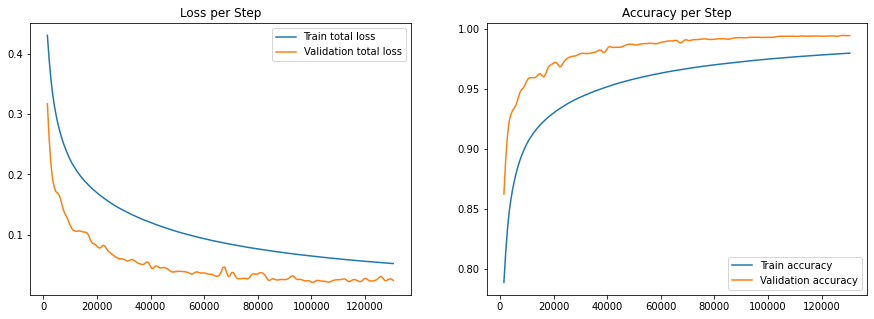

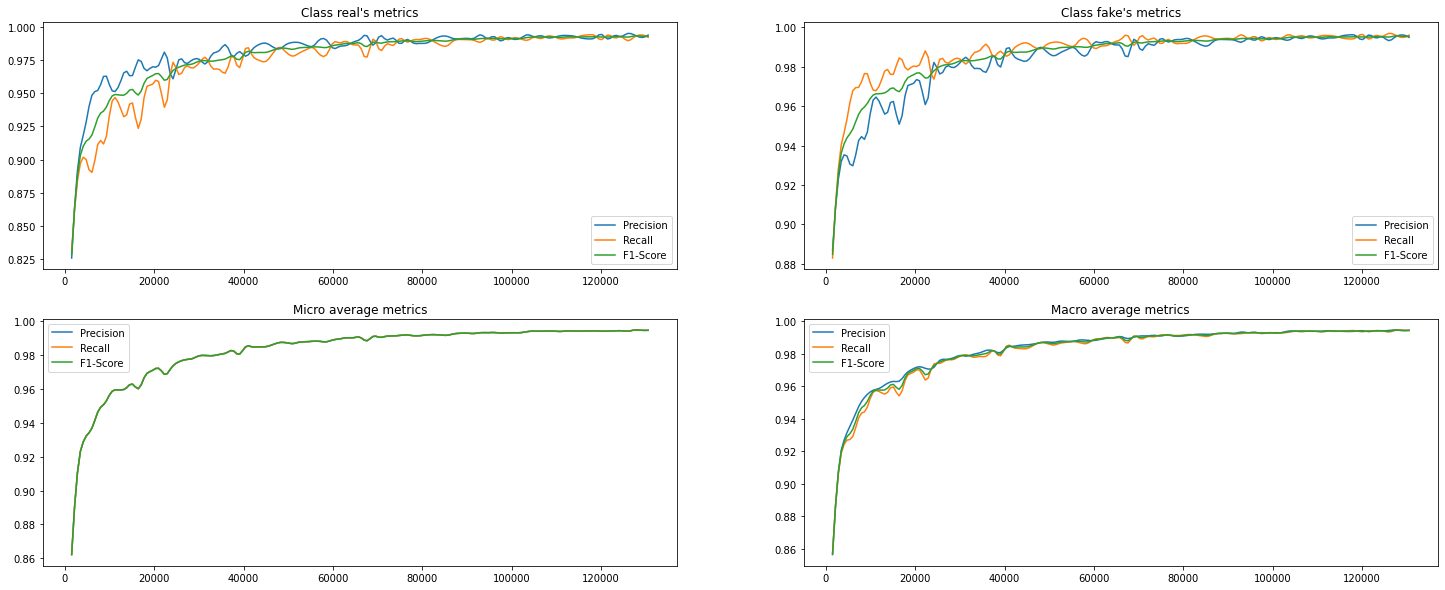

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

import os.path as osp
import csv
from typing import List

from torch import AnyType

def read_file(csv_file: str):
    """ 
    0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
    epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    epoch, Train loss, Train accuracy, Val loss,  Val accuracy,  Val real pre,  Val real rec,  Val real F1-Score,  Val fake pre,  Val fake rec,  Val fake F1-Score,  Val micro pre,  Val micro rec,  Val micro F1-Score, Val macro pre,  Val macro rec,  Val macro F1-Score
    Args:
        csv_file (str): path to file
    """
    global NUM_INFO
    result = [[] for _ in range(NUM_INFO)]
    # Read file
    file = open(csv_file)
    csvreader = csv.reader(file)
    # Get result:
    for idx, row in enumerate(csvreader):
        if idx == 0:
            continue
        for i in range(NUM_INFO):
            if i == 0:
                result[0].append(int(row[0]))
                continue
            result[i].append(float(row[i]))
    
    if 'test' in osp.basename(csv_file):
        phase = "Test"
    else:
        phase = "Validation"
        
    if 'epoch' in csv_file:
        iter_method = 'Epoch'
    else:
        iter_method = 'Step'
    
    results = []
    for i, r in enumerate(result):
        results.append(np.array(r, dtype=np.int32 if i == 0 else np.float32))
    return results, phase, iter_method

def plot_loss_and_accuracy(iter_loop: List[int], iter_method: str, values: List[List[float]], phase="Val"):
    """ values: [train_loss, train_acc, val_loss, val_acc]
    if pairwise: [train_contrastive_loss, train_bce_loss, train_total_loss, train_acc, val_contrastive, val_bce, val_total, val_accu]
    """
    plt.figure(figsize=(15, 5))
    # plt.subplot(2, 2, 1)
    # plt.plot(iter_loop, values[0], label="Train contrastive loss")
    # plt.plot(iter_loop, values[4], label=phase + " contrastive loss")
    # plt.legend()
    # plt.title("Loss per " + iter_method)

    # plt.subplot(2, 2, 2)
    # plt.plot(iter_loop, values[1], label="Train bce loss")
    # plt.plot(iter_loop, values[5], label=phase + " bce loss")
    # plt.legend()
    # plt.title("Loss per " + iter_method)
    # # plt.xticks([i for i in range(1, len(epochs)+1)])
    # # plt.yticks([0.1*i for i in range(1, 16)])
    
    plt.subplot(1, 2, 1)
    plt.plot(iter_loop, values[0], label="Train total loss")
    plt.plot(iter_loop, values[2], label=phase + " total loss")
    plt.legend()
    plt.title("Loss per " + iter_method)

    plt.subplot(1, 2, 2)
    plt.plot(iter_loop, values[1], label="Train accuracy")
    plt.plot(iter_loop, values[3], label=phase + " accuracy")
    plt.legend()
    plt.title("Accuracy per " + iter_method)
    plt.plot()
    # plt.savefig("result/Loss-Accuracy {} per {}.png".format(phase, iter_method))
    
def plot_metrics(iter_loop: List[int], iter_method: str, values: List[List[List[float]]], phase="Val"):
    """ values: [[pre, rec, f1] * [real, fake, micro, macro]]
    """
    plt.figure(figsize=(25, 10))
    assert len(values) == 4, "False parameter!"
    
    # i: 0 -> 3: real, fake, micro, macro
    title = ["Class real's metrics", "Class fake's metrics", "Micro average metrics", "Macro average metrics"]
    for i in range(0, 4):
        plt.subplot(2, 2, i+1)
        # j: 0 -> 2: precision, recall, f1-score
        plt.plot(iter_loop, values[i][0], label="Precision")
        plt.plot(iter_loop, values[i][1], label="Recall")
        plt.plot(iter_loop, values[i][2], label="F1-Score")
        plt.legend()
        plt.title(title[i])
    plt.plot()
    # plt.savefig("result/Metrics {} per {}.png".format(phase, iter_method))

def smooth_curve_with_pyplot(results: List[List[AnyType]], iter_method: str, phase='Val'):
    """results:
        0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
        epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    """
    from scipy.interpolate import make_interp_spline
    global NUM_INFO, INTERVAL, K_SPLINE_LOSS_ACC, K_SPLINE_METRIC
    
    iter_loop = results[0]
    iter_loop_new = np.linspace(iter_loop.min(), iter_loop.max(), INTERVAL)

    #define spline
    K = [-1] + [K_SPLINE_LOSS_ACC] * 8 + [K_SPLINE_METRIC] * 12
    spl = [make_interp_spline(iter_loop, results[i], k=K[i]) for i in range(1, NUM_INFO)]
    results_smooth = [-1] + [spl_item(iter_loop_new) for spl_item in spl]
    
    plot_loss_and_accuracy(iter_loop_new, iter_method, values=results_smooth[1:9], phase=phase)
    plot_metrics(iter_loop_new, iter_method, values=[results_smooth[5: 8], results_smooth[8: 11], results_smooth[11: 14], results_smooth[14: 17]], phase=phase)

def plot_graph(csv_file: str):
    if csv_file == '':
        return
    results, phase, iter_method = read_file(csv_file)
    smooth_curve_with_pyplot(results, iter_method, phase)

NUM_INFO = 17
INTERVAL = 200
K_SPLINE_LOSS_ACC = 2
K_SPLINE_METRIC = 2

if __name__ == '__main__':
    dict = {}
    methods = ['meso4', 'xception', 'dual_efficient', 'dual_attn_efficient', 'dual_efficient_vit']
    datasets = ['uadfv', 'ff_all', 'celeb_df', 'dfdc', 'df_in_the_wild']
    csv_file = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/test/df_in_the_wild/dual_efficient_vit/result_val.csv"
    # csv_file = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/test/result_test.csv"
    plot_graph(csv_file)

In [7]:
import torch
import torch.nn as nn

##########################################################################

def conv(in_channels, out_channels, kernel_size, bias=True, padding=1, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size // 2), bias=bias, stride=stride)


##########################################################################

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


##########################################################################

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


class spatial_attn_layer(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attn_layer, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        # import pdb;pdb.set_trace()
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale


##########################################################################


## Dual Attention Block (DAB)
class DAB(nn.Module):
    def __init__(self, n_feat: int, reduction: int, gamma_dab=-1, act_dab=None):
        super().__init__()
        self.SA = spatial_attn_layer()  ## Spatial Attention
        self.CA = CALayer(n_feat, reduction)  ## Channel Attention
        self.conv1x1 = nn.Conv2d(n_feat * 2, n_feat, kernel_size=1)
        if gamma_dab == -1:
            self.gamma = nn.Parameter(torch.ones(1))
        else:
            self.gamma = gamma_dab
        self.act = act_dab

    def forward(self, x):
        sa_branch = self.SA(x)
        ca_branch = self.CA(x)
        attn = torch.cat([sa_branch, ca_branch], dim=1)
        attn = self.conv1x1(attn)
        res = self.gamma * attn + x
        if self.act:
            res = self.act(res)
        return res

import torch.nn as nn
from torch import einsum
import torch
from torchsummary import summary
from einops import rearrange

import sys
from model.backbone.efficient_net.model import EfficientNet

import re
import torch.nn.functional as F

import re, math
from model.vision_transformer.vit.vit import ViT, Transformer
from model.vision_transformer.cnn_vit.efficient_vit import EfficientViT
from pytorchcv.model_provider import get_model

class CrossAttention(nn.Module):
    def __init__(self, in_dim, inner_dim=0, prj_out=False, qkv_embed=True, init_weight=True):
        super(CrossAttention, self).__init__()
        self.in_dim = in_dim
        self.qkv_embed = qkv_embed
        self.init_weight = init_weight
        self.to_out = nn.Identity()
        if self.qkv_embed:
            inner_dim = self.in_dim if inner_dim == 0 else inner_dim
            self.to_k = nn.Linear(in_dim, inner_dim, bias=False)
            self.to_v = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_q = nn.Linear(in_dim, inner_dim, bias = False)
            self.to_out = nn.Sequential(
                nn.Linear(inner_dim, in_dim),
                nn.Dropout(p=0.1)
            ) if prj_out else nn.Identity()

        if self.init_weight:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_normal_(m.weight.data, gain=0.02)

    def forward(self, x, y, z):
        """
            x ~ rgb_vectors: (b, n, in_dim)
            y ~ freq_vectors: (b, n, in_dim)
            z ~ freq_vectors: (b, n, in_dim)
            Returns:
                attn_weight: (b, n, n)
                attn_output: (b, n, in_dim)
        """
        if self.qkv_embed:
            q = self.to_q(x)
            k = self.to_k(y)
            v = self.to_v(z)
        else:
            q, k, v = x, y, z
        out, attn = self.scale_dot(q, k, v, dropout_p=0.00)
        out = self.to_out(out)
        return out, attn

    """
        Get from torch.nn.MultiheadAttention
        scale-dot: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L4966
        multi-head: https://github.com/pytorch/pytorch/blob/1c5a8125798392f8d7c57e88735f43a14ae0beca/torch/nn/functional.py#L5059
    """
    def scale_dot(self, q, k, v, attn_mask=None, dropout_p=0):
        B, Nt, E = q.shape
        q = q / math.sqrt(E)
        # (B, Nt, E) x (B, E, Ns) -> (B, Nt, Ns)
        attn = torch.bmm(q, k.transpose(-2, -1))
        if attn_mask is not None:
            attn += attn_mask
        attn = torch.nn.functional.softmax(attn, dim=-1)
        if dropout_p > 0.0:
            attn = torch.nn.functional.dropout(attn, p=dropout_p)
        # (B, Nt, Ns) x (B, Ns, E) -> (B, Nt, E)
        output = torch.bmm(attn, v)
        return output, attn

class DualDABCNNViT(nn.Module):
    def __init__(self, image_size=224, num_classes=1, dim=1024,\
                depth=6, heads=8, mlp_dim=2048,\
                dim_head=64, dropout=0.15,\
                backbone='xception_net', pretrained=True,\
                normalize_ifft='batchnorm',\
                flatten_type='patch',\
                conv_attn=False, ratio=5, qkv_embed=True, init_ca_weight=True, prj_out=False, inner_ca_dim=512, act='none',\
                patch_size=7, \
                version='ca-fcat-0.5', unfreeze_blocks=-1, dab_block4=True, red4=1, red10=1, gamma_dab=0.5, act_dab='none',\
                init_weight=False, init_linear="xavier", init_layernorm="normal", init_conv="kaiming", \
                dropout_in_mlp=0.0, classifier='mlp'):  
        super(DualDABCNNViT, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dim_head = dim_head
        self.dropout_value = dropout
        
        self.backbone = backbone
        self.features_size = {
            'efficient_net': (1280, 4, 4),
            'xception_net': (2048, 4, 4),
        }
        self.out_ext_channels = self.features_size[backbone][0]
        
        self.flatten_type = flatten_type # in ['patch', 'channel']
        self.version = version  # in ['ca-rgb_cat-0.5', 'ca-freq_cat-0.5']
        self.conv_attn = conv_attn
        self.activation = self.get_activation(act)

        self.pretrained = pretrained
        self.rgb_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=3)   # efficient_net-b0, return shape (1280, 8, 8) or (1280, 7, 7)
        self.freq_extractor = self.get_feature_extractor(architecture=backbone, pretrained=pretrained, unfreeze_blocks=unfreeze_blocks, num_classes=num_classes, in_channels=1)     
        self.normalize_ifft = normalize_ifft
        if self.normalize_ifft == 'batchnorm':
            self.batchnorm_ifft = nn.BatchNorm2d(num_features=self.out_ext_channels)
        if self.normalize_ifft == 'layernorm':
            self.layernorm_ifft = nn.LayerNorm(normalized_shape=self.features_size[self.backbone])
        ############################# PATCH CONFIG ################################
        
        if self.flatten_type == 'patch':
            # Kích thước của 1 patch
            self.patch_size = patch_size
            # Số lượng patches
            self.num_patches = int((self.features_size[backbone][1] * self.features_size[backbone][2]) / (self.patch_size * self.patch_size))
            # Patch_dim = P^2 * C
            self.patch_dim = self.out_ext_channels//ratio * (self.patch_size ** 2)

        ############################# CROSS ATTENTION #############################
        if self.flatten_type == 'patch':
            self.in_dim = self.patch_dim
        else:
            self.in_dim = int(self.features_size[backbone][1] * self.features_size[backbone][2])
        if self.conv_attn:
            self.query_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.key_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)
            self.value_conv = nn.Conv2d(in_channels=self.out_ext_channels, out_channels=self.out_ext_channels//ratio, kernel_size=1)

        self.dab_block4 = dab_block4
        self.gamma_dab = gamma_dab
        self.act_dab = self.get_activation(act=act_dab)
        if self.dab_block4:
            self.dab_b4_rgb = DAB(n_feat=40, reduction=red4, gamma_dab=self.gamma_dab, act_dab=self.act_dab)
            self.dab_b4_freq = DAB(n_feat=40, reduction=red4, gamma_dab=self.gamma_dab, act_dab=self.act_dab)
        self.dab_b10_rgb = DAB(n_feat=112, reduction=red10, gamma_dab=self.gamma_dab, act_dab=self.act_dab)
        self.dab_b10_freq = DAB(n_feat=112, reduction=red10, gamma_dab=self.gamma_dab, act_dab=self.act_dab)

        self.CA = CrossAttention(in_dim=self.in_dim, inner_dim=inner_ca_dim, prj_out=prj_out, qkv_embed=qkv_embed, init_weight=init_ca_weight)

        ############################# VIT #########################################
        # Giảm chiều vector sau concat 2*patch_dim về D:
        if 'cat' in self.version:
            self.embedding = nn.Linear(2 * self.in_dim, self.dim)
        else:
            self.embedding = nn.Linear(self.in_dim, self.dim)

        # Thêm 1 embedding vector cho classify token:
        self.classifier = classifier
        self.num_vecs = self.num_patches if self.flatten_type == 'patch' else self.out_ext_channels//ratio
        if 'vit' in self.classifier:
            self.transformer = Transformer(self.dim, self.depth, self.heads, self.dim_head, self.mlp_dim, self.dropout_value)
            self.batchnorm = nn.BatchNorm1d(self.num_vecs)
        if 'vit_aggregate' in self.classifier:
            gamma = float(self.classifier.split('_')[-1])
            if gamma == -1:
                self.gamma = nn.Parameter(torch.ones(1))
            else:
                self.gamma = gamma

        self.mlp_relu = nn.ReLU(inplace=True)
        self.mlp_head_hidden = nn.Linear(self.dim, self.mlp_dim)
        self.mlp_dropout = nn.Dropout(dropout_in_mlp)
        self.mlp_head_out = nn.Linear(self.mlp_dim, self.num_classes)
        self.sigmoid = nn.Sigmoid()
        self.init_linear, self.init_layernorm, self.init_conv = init_linear, init_layernorm, init_conv
        if init_weight:
            self.apply(self._init_weights)

    def get_activation(self, act):
        if act == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act == 'tanh':
            activation = nn.Tanh()
        elif act == 'sigmoid':
            activation = nn.Sigmoid()
        elif act == 'leakyrely':
            activation = nn.LeakyReLU()
        elif act == 'selu':
            activation = nn.SELU()
        elif act == 'gelu':
            activation = nn.GELU()
        else:
            activation = None
        return activation

    def init_conv_weight(self, module):
        for ly in module.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None:
                    nn.init.constant_(ly.bias, 0)
            elif isinstance(ly, nn.Module):
                self.init_conv_weight(ly)

    def init_transformer_weights(self, module):
        if isinstance(module, nn.Linear):
            print("Linear: ", module)
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # print("Linear: ", module)
            if self.init_linear == 'normal':
                module.weight.data.normal_(mean=0.0, std=1.0)
            elif self.init_linear == 'xavier':
                nn.init.xavier_uniform_(module.weight)
            else:
                pass
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            # print("Layer norm: ", module)
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, nn.Conv2d) and self.pretrained == 0:
            # print("Conv: ", module)
            if self.init_conv == 'kaiming':
                nn.init.kaiming_normal_(module.weight, a=1)
            elif self.init_conv == "xavier":
                nn.init.xavier_uniform_(module.weight)
            else:
                pass

            if not module.bias is None:
                nn.init.constant_(module.bias, 0)

    def get_feature_extractor(self, architecture="efficient_net", unfreeze_blocks=-1, pretrained=False, num_classes=1, in_channels=3):
        extractor = None
        if architecture == "efficient_net":
            extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,in_channels = in_channels, pretrained=bool(pretrained))
            if unfreeze_blocks != -1:
                # Freeze the first (num_blocks - 3) blocks and unfreeze the rest 
                for i in range(0, len(extractor._blocks)):
                    for index, param in enumerate(extractor._blocks[i].parameters()):
                        if i >= len(extractor._blocks) - unfreeze_blocks:
                            param.requires_grad = True
                        else:
                            param.requires_grad = False
        
        if architecture == 'xception_net':
            xception = get_model("xception", pretrained=bool(pretrained))
            extractor = nn.Sequential(*list(xception.children())[:-1])
            extractor[0].final_block.pool = nn.Identity()
            if in_channels != 3:
                extractor[0].init_block.conv1.conv = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

            if unfreeze_blocks != -1:
                blocks = len(extractor[0].children())
                print("Number of blocks in xception: ", len(blocks))
                for i, block in enumerate(extractor[0].children()):
                    if i >= blocks - unfreeze_blocks:
                        for param in block.parameters():
                            param.requires_grad = True
                    else:
                        for param in block.parameters():
                            param.requires_grad = False
        print("Pretrained backbone: ", bool(pretrained))
        # if not pretrained:
        #     self.init_conv_weight(extractor)
        return extractor

    def flatten_to_vectors(self, feature):
        vectors = None
        if self.flatten_type == 'patch':
            vectors = rearrange(feature, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        elif self.flatten_type == 'channel':
            vectors = rearrange(feature, 'b c h w -> b c (h w)')
        else:
            pass
        return vectors

    def ifft(self, freq_feature, norm_type='none'):
        ifreq_feature = torch.log(torch.abs(torch.fft.ifft2(torch.fft.ifftshift(freq_feature))) + 1e-10)  # Hơi ảo???
        if norm_type == 'none':
            pass
        elif norm_type == 'batchnorm':
            ifreq_feature = self.batchnorm_ifft(ifreq_feature)
        elif norm_type == 'layernorm':
            ifreq_feature = self.layernorm_ifft(ifreq_feature)
        elif norm_type == 'normal':
            ifreq_feature = F.normalize(ifreq_feature)
        elif norm_type == 'no_ifft':
            return freq_feature
        return ifreq_feature

    def fusion(self, rgb, out_attn):
        """
        Arguments:
            rgb --      b, n, d
            out_attn -- b, n, d
        """
        weight = float(self.version.split('-')[-1])
        if 'cat' in self.version:
            out = torch.cat([rgb, weight * out_attn], dim=2)
        elif 'add' in self.version:
            out = torch.add(rgb, weight * out_attn)
        return out

    def extract_feature(self, rgb_imgs, freq_imgs):
        if self.backbone == 'efficient_net':
            #
            rgb_features = self.rgb_extractor.extract_features_block_4(rgb_imgs)                 # shape (batchsize, 1280, 8, 8)
            freq_features = self.freq_extractor.extract_features_block_4(freq_imgs)              # shape (batchsize, 1280, 4, 4)
            print(rgb_features.shape)
            if self.dab_block4:
                rgb_features = self.dab_b4_rgb(rgb_features)
                freq_features = self.dab_b4_freq(freq_features)
            #
            rgb_features = self.rgb_extractor.extract_features_block_11(rgb_features)
            freq_features = self.freq_extractor.extract_features_block_11(freq_features)
            rgb_features = self.dab_b10_rgb(rgb_features)
            freq_features = self.dab_b10_freq(freq_features)
            #
            rgb_features = self.rgb_extractor.extract_features_last_block_2(rgb_features)
            freq_features = self.freq_extractor.extract_features_last_block_2(freq_features)
        else:
            rgb_features = self.rgb_extractor(rgb_imgs)
            freq_features = self.freq_extractor(freq_imgs)
        return rgb_features, freq_features

    def forward(self, rgb_imgs, freq_imgs):
        rgb_features, freq_features = self.extract_feature(rgb_imgs, freq_imgs)
        ifreq_features = self.ifft(freq_features, norm_type=self.normalize_ifft)
        # print("Features shape: ", rgb_features.shape, freq_features.shape, ifreq_features.shape)

        # Turn to q, k, v if use conv-attention, and then flatten to vector:
        if self.conv_attn:
            rgb_query = self.query_conv(rgb_features)
            freq_value = self.value_conv(freq_features)
            ifreq_key = self.key_conv(ifreq_features)
            ifreq_value = self.value_conv(ifreq_features)
        else:
            rgb_query = rgb_features
            freq_value = freq_features
            ifreq_key = ifreq_features
            ifreq_value = ifreq_features
        # print("Q K V shape: ", rgb_query.shape, freq_value.shape, ifreq_key.shape, ifreq_value.shape)
        rgb_query_vectors = self.flatten_to_vectors(rgb_query)
        freq_value_vectors = self.flatten_to_vectors(freq_value)
        ifreq_key_vectors = self.flatten_to_vectors(ifreq_key)
        ifreq_value_vectors = self.flatten_to_vectors(ifreq_value)
        # print("Vectors shape: ", rgb_query_vectors.shape, freq_value_vectors.shape, ifreq_key_vectors.shape, ifreq_value_vectors.shape)

        ##### Cross attention and fusion:
        out, attn_weight = self.CA(rgb_query_vectors, ifreq_key_vectors, ifreq_value_vectors)
        attn_out = torch.bmm(attn_weight, freq_value_vectors)
        fusion_out = self.fusion(rgb_query_vectors, attn_out)
        if self.activation is not None:
            fusion_out = self.activation(fusion_out)
        # print("Fusion shape: ", fusion_out.shape)
        embed = self.embedding(fusion_out)
        # print("Inner ViT shape: ", embed.shape)

        ##### Forward to ViT
        if self.classifier == 'mlp':
            x = embed.mean(dim = 1).squeeze(dim=1)     # B, N, D => B, 1, D
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if self.classifier == 'vit':
            x = self.transformer(embed)
            # sys.stdout = open('/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/check.txt', 'w')
            # print(x[0])
            # sys.stdout = sys.__stdout__
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)

        if 'vit_aggregate' in self.classifier:
            x = self.transformer(embed)
            # x = self.batchnorm(x)    
            x = embed + self.gamma * x
            x = x.mean(dim = 1).squeeze(dim=1)
            x = self.mlp_dropout(x)         
            x = self.mlp_head_hidden(x) # B, 1, D => 
            x = self.mlp_relu(x)
            x = self.mlp_dropout(x)
            x = self.mlp_head_out(x)
        x = self.sigmoid(x)
        return x

from torchsummary import summary
if __name__ == '__main__':
    x = torch.ones(32, 3, 128, 128)
    y = torch.ones(32, 1, 128, 128)
    model_ = DualDABCNNViT(  image_size=128, num_classes=1, dim=1024,\
                                depth=6, heads=8, mlp_dim=2048,\
                                dim_head=64, dropout=0.15, \
                                backbone='efficient_net', pretrained=False,\
                                normalize_ifft=True,\
                                flatten_type='patch',\
                                conv_attn=True, ratio=8, qkv_embed=True, inner_ca_dim=0, init_ca_weight=True, prj_out=False, act='selu',\
                                patch_size=1, \
                                version='ca-fcat-0.5', unfreeze_blocks=-1, classifier='mlp', \
                                dab_block4=True, red4=1, red10=1, gamma_dab=0.5, act_dab='none')
    out = model_(x, y)
    print(out.shape)

Pretrained backbone:  False
Pretrained backbone:  False
torch.Size([32, 40, 16, 16])
torch.Size([32, 1])


REAL IMAGE: 
 - Image:  yzasourxza_0.jpg
(422, 301, 2)
dft_shift:  (422, 301, 2)
mask : 


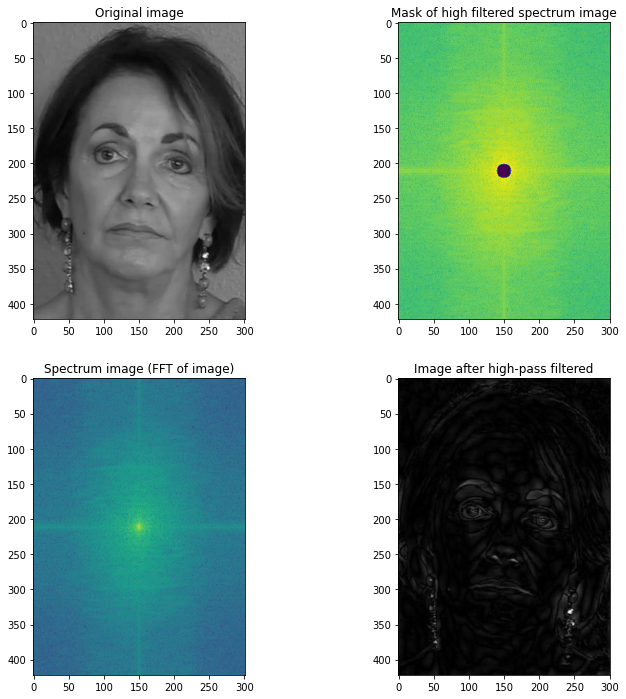

(422, 301)
dft_shift:  (422, 301)
mask :  (422, 301)


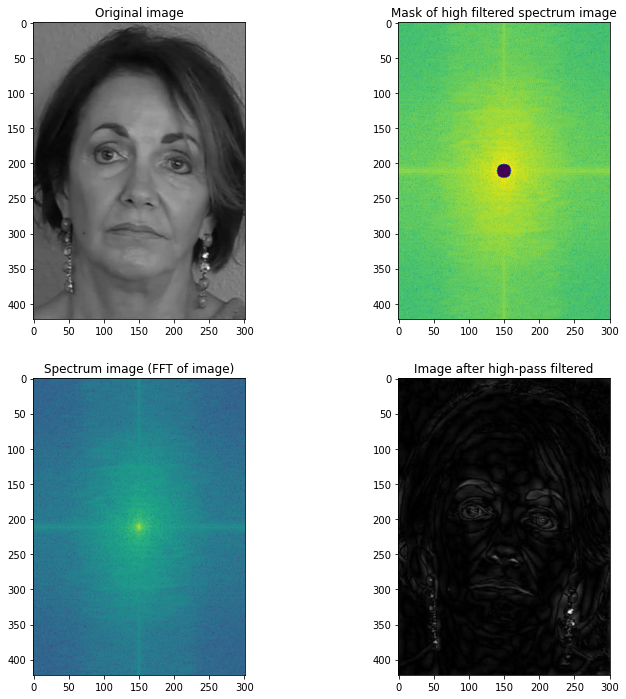

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import os.path as osp

img_path = "test/dft_test.jpg"
def visualize_highpass_filter(img_path: str, ratio: int, use_cv=True):
    img = cv2.imread(img_path, flags=0)
    if use_cv:
        # print(img)

        # DFT image:
        # @param: src: cần chuyển image sang float, flags=DFT_COMPLEX_OUTPUT để trả về kết quả là ma trận DFT cả real và imaginary
        # @return: [H, W, 2] (2: real và imaginary)
        dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

        # Chú ý rằng theo công thức: X_{k, l} = sigma_{n=0}{W-1}sigma_{m=0}{H-1} x_{n, m}. e^[-i*2pi*(k*n/W + l*m/H)]
        # Điểm (k, l) trên ảnh spectrum (trên miền tần số) sẽ là: 
        # tổng hợp các thành phần tần số (k*n/W + l*m/H) với n, m chạy từ 0->W-1, 0->H-1
        # nên tại (k, l) càng bé (ví dụ top-left) thì tần số sẽ là 0
        # càng ra xa dần thì tần số sẽ càng lớn
        # Cho nên: ta mong muốn transform spectrum image này sao cho ở tâm ảnh tần số càng bé (ví dụ 0)
        # càng ra xa dần tần số càng lớn
        # => np.fft.shift
        dft_shift = np.fft.fftshift(dft)

        # Cộng với 1 lượng epsilon để có thể tính log:
        dft_shift += 1e-5
        print(dft_shift.shape)

        # dft_shift vẫn đang là complex => Ta tìm biên độ của phổ của ảnh:
        magnitude_spectrum_1 = cv2.magnitude(dft_shift[:,:,0], dft_shift[:, :, 1])
        magnitude_spectrum_2 = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:, :, 1]))

        """
            Ảnh sẽ như thế nào nếu lọc đi tần số thấp?
        """
        # High-pass filter mask: Lọc freq thấp (ở giữa tâm ảnh spectrum)
        H, W = img.shape[:2]
        crow, ccol = H//2, W//2

        # Create a mask with two channels because DFT result in 2D
        mask = np.ones((H, W, 2), dtype=np.uint8)

        # Circular radius from center
        r = H // ratio
        center = [crow, ccol]

        # @return x: np.ndarray([[0], [1]...[H-1]], shape=(H, 1))
        # @return y: np.ndarray([[0, 1... W-1]], shape=(1, W))
        x, y = np.ogrid[:H, :W]

        # Tạo mask_area: Lọc các tần số thấp <=> mask = 0
        mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
        mask[mask_area] = 0

        print("dft_shift: ", dft.shape)
        print("mask : ")
        f_shift = dft_shift * mask
        f_shift += 1e-5

        filtered_magnitude_spectrum = 20 * np.log(cv2.magnitude(np.array(f_shift[:, :, 0], dtype=np.float32), \
                                                                np.array(f_shift[:, :, 1], dtype=np.float32)))

        f_ishift = np.fft.ifftshift(f_shift)
        img_back = cv2.idft(f_ishift)
        img_back = cv2.magnitude(np.array(img_back[:, :, 0], dtype=np.float32), \
                                np.array(img_back[:, :, 1], dtype=np.float32))

        # Plot:
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original image')
        plt.subplot(2, 2, 3)
        plt.imshow(magnitude_spectrum_2)
        plt.title('Spectrum image (FFT of image)')
        plt.subplot(2, 2, 2)
        # High-pass filtering: Edge detector
        plt.imshow(filtered_magnitude_spectrum)
        plt.title('Mask of high filtered spectrum image')
        plt.subplot(2, 2, 4)
        plt.imshow(img_back, cmap='gray')
        plt.title('Image after high-pass filtered')
        plt.show()
    else:
        dft = np.fft.fft2(img)
        dft_shift = np.fft.fftshift(dft)

        # Cộng với 1 lượng epsilon để có thể tính log:
        dft_shift += 1e-5
        print(dft_shift.shape)

        # dft_shift vẫn đang là complex => Ta tìm biên độ của phổ của ảnh:
        magnitude_spectrum_2 = 20 * np.log(np.abs(dft_shift))

        """
            Ảnh sẽ như thế nào nếu lọc đi tần số thấp?
        """
        # High-pass filter mask: Lọc freq thấp (ở giữa tâm ảnh spectrum)
        H, W = img.shape[:2]
        crow, ccol = H//2, W//2

        # Create a mask with two channels because DFT result in 2D
        mask = np.ones((H, W), dtype=np.uint8)

        # Circular radius from center
        r = H // ratio
        center = [crow, ccol]

        # @return x: np.ndarray([[0], [1]...[H-1]], shape=(H, 1))
        # @return y: np.ndarray([[0, 1... W-1]], shape=(1, W))
        x, y = np.ogrid[:H, :W]

        # Tạo mask_area: Lọc các tần số thấp <=> mask = 0
        mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
        mask[mask_area] = 0

        print("dft_shift: ", dft.shape)
        print("mask : ", mask.shape)
        f_shift = dft_shift * mask
        f_shift += 1e-5

        filtered_magnitude_spectrum = 20 * np.log(np.abs(f_shift))

        f_ishift = np.fft.ifftshift(f_shift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)

        # Plot:
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original image')
        plt.subplot(2, 2, 3)
        plt.imshow(magnitude_spectrum_2)
        plt.title('Spectrum image (FFT of image)')
        plt.subplot(2, 2, 2)
        # High-pass filtering: Edge detector
        plt.imshow(filtered_magnitude_spectrum)
        plt.title('Mask of high filtered spectrum image')
        plt.subplot(2, 2, 4)
        plt.imshow(img_back, cmap='gray')
        plt.title('Image after high-pass filtered')
        plt.show()

import os
ratio = 40
imgs_path = "/mnt/disk1/doan/phucnp/Dataset/dfdcv5/image/train/0_real"
imgs_list = os.listdir(imgs_path)
print("REAL IMAGE: ")
for img_path in imgs_list[:1]:
    print(" - Image: ", img_path)
    visualize_highpass_filter(img_path=os.path.join(imgs_path, img_path), ratio=ratio, use_cv=True)
    visualize_highpass_filter(img_path=os.path.join(imgs_path, img_path), ratio=ratio, use_cv=False)

# imgs_path = "/mnt/disk1/doan/phucnp/Dataset/dfdcv5/image/train/1_df"
# imgs_list = os.listdir(imgs_path)
# print("\nFAKE IMAGE: ")
# for img_path in imgs_list[:20]:
#     print(" - Image: ")
#     visualize_highpass_filter(img_path=os.path.join(imgs_path, img_path), ratio=ratio)


